In [1]:
from sklearn.cluster import KMeans
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import numpy as np
import importlib
import os, sys
from src.components.ObjectDetector import ObjectDetector
from src.components.PlateReader import PlateReader
from src.objects.Cascades import FrameTree
from src.config import *
from src.modules.utils import *
from src.modules.preprocess import display, save_display

importlib.reload(sys.modules['src.components.ObjectDetector'])
importlib.reload(sys.modules['src.components.PlateDetector'])
importlib.reload(sys.modules['src.objects.Cascades'])
importlib.reload(sys.modules['src.modules.utils'])
importlib.reload(sys.modules['src.modules.preprocess'])
importlib.reload(sys.modules['src.config'])

<module 'src.config' from 'c:\\users\\user\\projects\\20231019-traffic-management\\src\\config.py'>

In [2]:
model_car = YOLO(WEIGHTS_PATH)
model_plate = YOLO(PLATE_WEIGHTS)
model_ocr = YOLO(OCR_WEIGHTS)

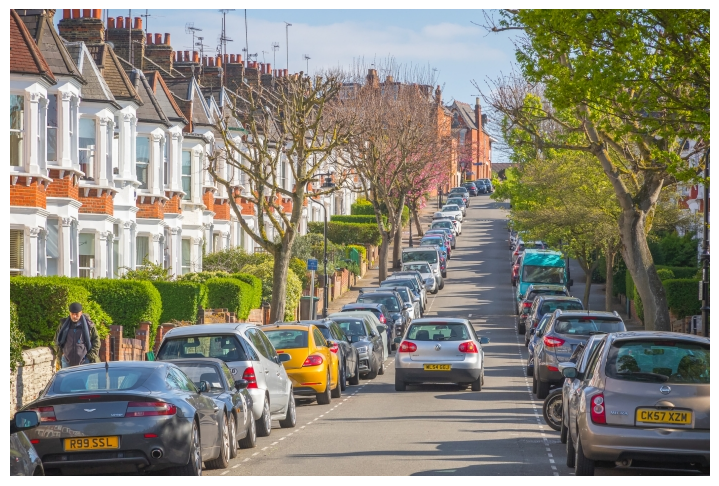

In [3]:
img = r'C:\Users\USER\Projects\20231019-traffic-management\notebook\images\cars.jpg'
display(img)
img = cv2.imread(img)

In [4]:
cur_detect, next_detect = latest_version_file(r'tree\detections', name='detect')
print(cur_detect, next_detect)
cur_plate, next_plate = latest_version_file(r'tree\cascades', name='plate')
print(cur_plate, next_plate)

detect30.pkl detect31.pkl
plate30.pkl plate31.pkl


In [5]:
detector = ObjectDetector(model=model_car, classes=CLASSES, conf_threshold=0.5)
recognizer = PlateReader(model_plate=model_plate, model_ocr=model_ocr)

ObjectDetector.__init__() took 0.0 seconds

PlateDetector.__init__() took 13.366929054260254 seconds



In [6]:
detector.Detect(frame=img, mask=None)
detector.saveTree(path=f'tree\\detections\\{next_detect}')
recognizer.Detect(img, save=True, save_txt=True, project=r'annotate\plates', name='plate')
recognizer.saveTree(path=f'tree\\cascades\\{next_plate}')


0: 448x640 10 cars, 205.7ms
Speed: 31.3ms preprocess, 205.7ms inference, 52.7ms postprocess per image at shape (1, 3, 448, 640)



FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (467, 700, 3)
Root Child Count:  10
Root Depth:  1
Tree Diagram: 
root
├── [1] car
├── [2] car
├── [3] car
├── [4] car
├── [5] car
├── [6] car
├── [7] car
├── [8] car
├── [9] car
└── [10] car

{self.__class__.__name__}.Detect() took 7.987406253814697 seconds

Frame Tree saved to: tree\detections\detect31.pkl



0: 448x640 1 license plate, 267.3ms
Speed: 10.2ms preprocess, 267.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to annotate\plates\plate49
1 label saved to annotate\plates\plate49\labels



FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (467, 700, 3)
Root Child Count:  1
Root Depth:  1
Tree Diagram: 
root
└── [1] license plate

PlateReader.Read() took 2.2297656536102295 seconds

Frame Tree saved to: tree\cascades\plate31.pkl


In [7]:
detector.loadTree(path=f'tree\\detections\\{next_detect}')
recognizer.loadTree(path=f'tree\\cascades\\{next_plate}')
detector.frame_nodes.summarize()
recognizer.frame_nodes.summarize()

Loading Frame Tree from: tree\detections\detect31.pkl
Loading Frame Tree from: tree\cascades\plate31.pkl

FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (467, 700, 3)
Root Child Count:  10
Root Depth:  1
Tree Diagram: 
root
├── [1] car
├── [2] car
├── [3] car
├── [4] car
├── [5] car
├── [6] car
├── [7] car
├── [8] car
├── [9] car
└── [10] car


FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (467, 700, 3)
Root Child Count:  1
Root Depth:  1
Tree Diagram: 
root
└── [1] license plate



In [8]:
annotate_img = plot_box(img, detector.frame_nodes.bboxes, color=(0,255,0))
annotate_img = plot_box(annotate_img, recognizer.frame_nodes.bboxes, color=(255,0,255))

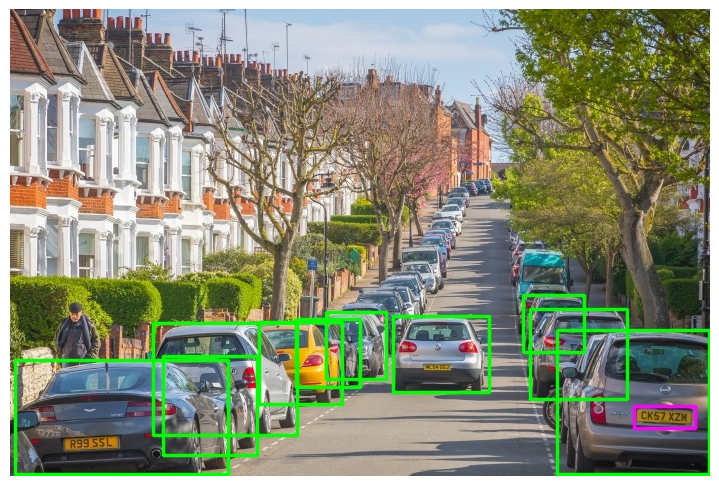

In [9]:
save_display(annotate_img, project='annotate\plot', name='image0')

In [10]:
import time
start = time.time()
union_node = detector.frame_nodes.deepUnion(recognizer.frame_nodes)
union_node.summarize()
print('Finished in', time.time() - start)


FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (467, 700, 3)
Root Child Count:  11
Root Depth:  2
Tree Diagram: 
root
├── [1] car
│       └── [1] license plate
├── [2] car
├── [3] car
├── [4] car
├── [5] car
├── [6] car
├── [7] car
├── [8] car
├── [9] car
└── [10] car

Finished in 0.010623693466186523


0.006220102310180664


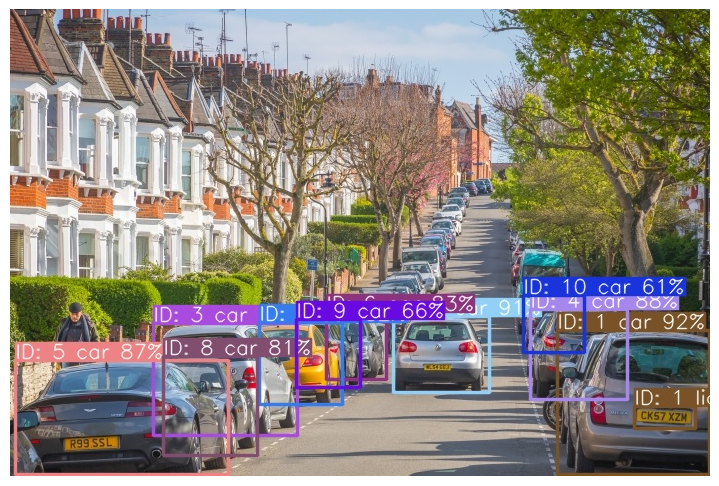

In [11]:
start = time.time()
frame = union_node.plot(seperate=True)
print(time.time() - start)
save_display(frame, project='temp', name='image')
# ID: 3   license plate   71 % bbox (xyxy): [193, 1008, 344, 1049]
# ID: 1   license plate   75 % bbox (xyxy): [1791, 1049, 1944, 1094]
# ID: 2   license plate   75 % bbox (xyxy): [996, 1006, 1148, 1048]

In [12]:
union_node.getChild(0).id

1

In [13]:
# def iob_matched_idx(candidates:np.ndarray, objects:np.ndarray):
#     scores = [[IOB(cand, obj) for cand in candidates] for obj in objects]
#     return np.argmax(scores, axis=1)

# def labels_list(candidates:np.ndarray, objects:np.ndarray):
#     idx = iob_matched_idx(candidates, objects)
#     labels = np.array([i for i in range(len(candidates))])
#     labels = np.append(labels, idx)
#     return labels

# labels = labels_list(car_boxes, plate_boxes)
# boxes = np.append(car_boxes, plate_boxes, axis=0)
# annotate_img = plot_matched_nodes(img, boxes, labels)
# save_display(annotate_img, project='annotate\plot', name='image')

In [14]:
# def filter_labels(labels, min_nodes=2):
#    unique_labels, counts = np.unique(labels, return_counts=True)
#    label_count_dict = dict(zip(unique_labels, counts))
#    # print(counts)
#    def map_funct(label):
#       if label_count_dict[label] < min_nodes:
#          return -1
#       else:
#          return label
#    labels = list(map(map_funct, labels))
#    return labels


# def plot_matched_nodes(frame, boxes, labels):
#    import random
#    labels = filter_labels(labels)
#    annotate_frame = frame.copy()
#    unique_labels = list(set(labels))
#    color = {}
#    for label in unique_labels:
#       color[label] = None if label == -1 \
#                   else (random.randint(0,255), random.randint(0,255), random.randint(0,255))
#    for i, box in enumerate(boxes):
#       # transform the bbox to the root coordinate and plot
#       annotate_frame = plot_box(annotate_frame, [box], color=color[labels[i]])
#    return annotate_frame

In [15]:
# file_car, _ = latest_version_file(path=r'annotate\vehicles', name='vehicle')
# label_car = os.path.join(r'annotate\vehicles', file_car, r'labels\image0.txt')
# file_plate, _ = latest_version_file(path=r'annotate\plates', name='plate')
# label_plate = os.path.join(r'annotate\plates', file_plate, r'labels\image0.txt')
# print(file_car, file_plate, label_car, label_plate)

# img_h, img_w = img.shape[:2]
# print(img_h, img_w)
# boxes = None

# def map_to_image_space(array):
#     x, y, w, h = array[0], array[1], array[2], array[3]
#     # print(x, y)
#     x1, y1, x2, y2 = x-w/2, y-h/2, x+w/2, y+h/2
#     x1, x2 = int(x1*img_w), int(x2*img_w)
#     y1, y2 = int(y1*img_h), int(y2*img_h)
#     return x1, y1, x2, y2

# def labels_to_boxes_operation(label_file):
#     label_array = np.loadtxt(label_file, dtype=float)
#     label_array = label_array[:, 1:-1]
#     label_array = np.array(list(map(map_to_image_space, label_array)))
#     # print(label_array)
#     return label_array

# car_boxes = labels_to_boxes_operation(label_car)
# plate_boxes = labels_to_boxes_operation(label_plate)
# # print(car_boxes)
# # print(plate_boxes)